In [45]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import numpy as np

In [46]:
df = pd.read_csv("nft_assets_floor_combined_2022-05-17_2.csv")

In [47]:
df = df.drop_duplicates(subset=['ownerAddress', 'tokenId','collectionOpenSeaSlug'], keep='last')

# Floor Collection

### Number of unique holders of Floor NFT Collections

## Collection Stats

In [4]:
floor_app = df.query('collectionOpenSeaSlug == "floor-app"').head(1).iloc[0]

In [5]:
floor_app.totalVolume

302.2240899

In [6]:
floor_app.floorPrice

1.15

In [7]:
floor_app.numberOfOwners

332

In [8]:
floor_beta = df.query('collectionOpenSeaSlug == "floor-beta"').head(1).iloc[0]

In [9]:
floor_beta.totalVolume

128.571686720258

In [10]:
floor_beta.floorPrice

0.31

In [11]:
floor_beta.numberOfOwners

679

In [12]:
floor_gen3 = df.query('collectionOpenSeaSlug == "floor-gen3"').head(1).iloc[0]

In [13]:
floor_gen3.totalVolume

91.9975398990002

In [14]:
floor_gen3.floorPrice

0.148

In [15]:
floor_gen3.numberOfOwners

1575

## Other NFT collections held by Floor holders

<AxesSubplot:xlabel='collectionOpenSeaSlug'>

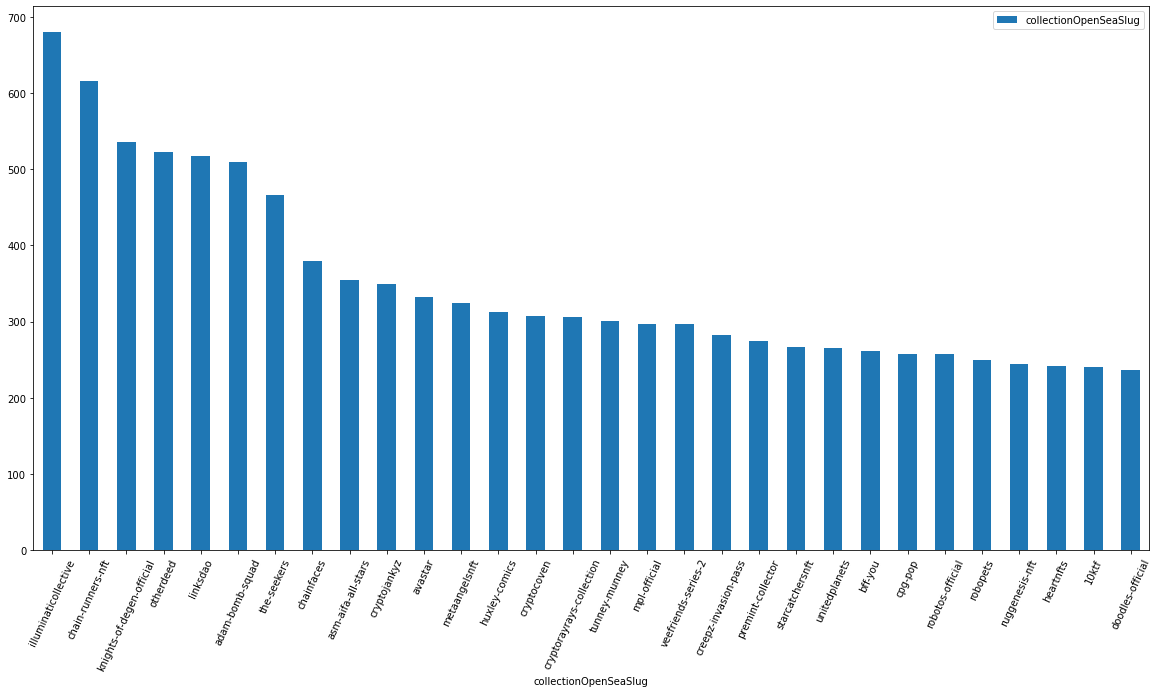

In [16]:
plot_df = df[ (df['collectionOpenSeaSlug'] != "floor-app") & (df['collectionOpenSeaSlug'] != "floor-beta") & (df['collectionOpenSeaSlug'] != "floor-gen3") ]
plot_df = pd.DataFrame(plot_df.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"].count().sort_values(ascending=False))
plot_df.head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)

### What are the most similar Floor holders holding

In [17]:
ocs = df.groupby(["ownerAddress", "collectionOpenSeaSlug"]).count()

In [18]:
ocs_count = ocs['assetContractAddress']
ocs_index = ocs_count.reset_index()
ocs_matrix = ocs_index.pivot(index='ownerAddress', columns='collectionOpenSeaSlug', values='assetContractAddress').fillna(0)

In [19]:
similarity_matrix = pd.DataFrame(
    squareform(pdist(ocs_matrix, metric='cosine')),
    columns = ocs_matrix.index,
    index = ocs_matrix.index
)

In [20]:
similarity_pairs = similarity_matrix.unstack()
similarity_pairs.index.rename(['Address A', 'Address B'], inplace=True)
similarity_pairs = similarity_pairs.to_frame('cosine distance').reset_index()

In [21]:
somewhat_similar = similarity_pairs[
    (similarity_pairs['cosine distance'] < 0.10) 
    & (similarity_pairs['cosine distance'] > 0.03) 
    & (similarity_pairs['Address A'] != similarity_pairs['Address B'])
].sort_values(by='cosine distance')

In [22]:
appended=pd.DataFrame(somewhat_similar.drop(columns='cosine distance').stack().reset_index()).drop(columns=['level_0', 'level_1'])
appended=appended.rename(columns={appended.columns[0]: "address"})
appended=appended.drop_duplicates()
indexed_address= appended.set_index('address')
indexed_df = df.set_index('ownerAddress')
similar_filtered = indexed_df[indexed_df.index.isin(indexed_address.index)].reset_index()
similar_filtered = similar_filtered[ (similar_filtered['collectionOpenSeaSlug'] != "floor-app") & (similar_filtered['collectionOpenSeaSlug'] != "floor-beta") & (similar_filtered['collectionOpenSeaSlug'] != "floor-gen3") ]

<AxesSubplot:xlabel='collectionOpenSeaSlug'>

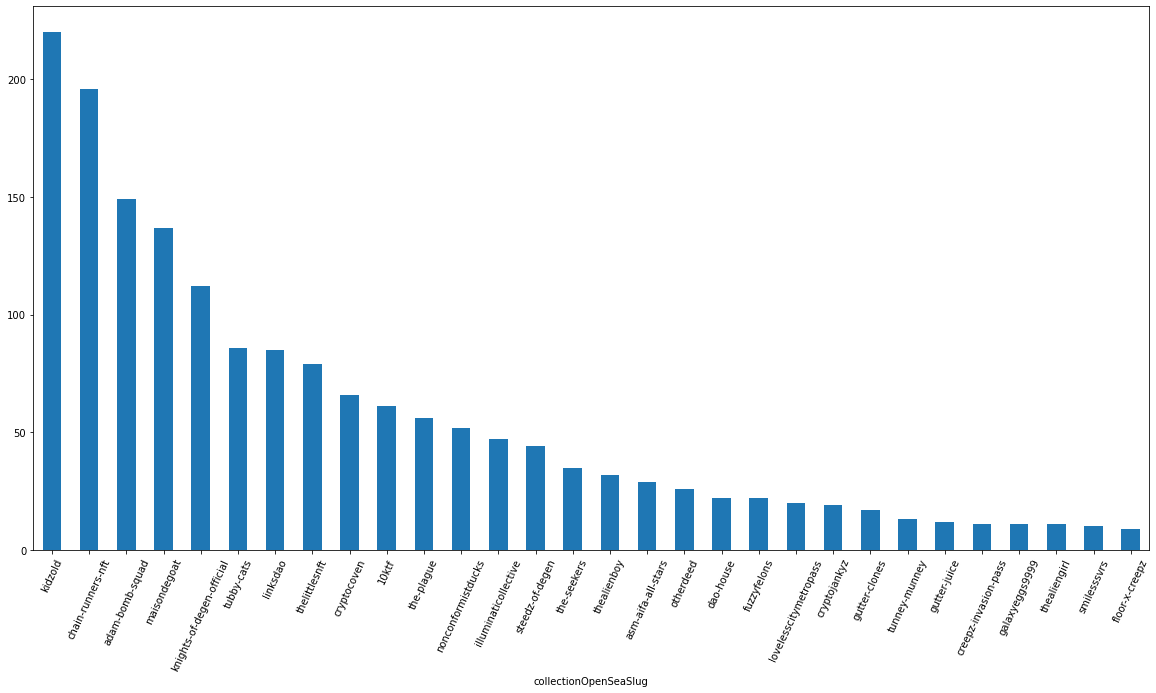

In [23]:
similar_filtered.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"] \
    .count() \
    .sort_values(ascending=False) \
    .head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)

In [24]:
def containsCollections(group, collections):
    strings = group['collectionOpenSeaSlug'].unique()
    contains = np.isin(element=strings, test_elements=collections)
    count = contains.sum()
    if count == len(collections):
        return group

In [25]:
def getSizeOfGroup(df, collections):
    return df.groupby('ownerAddress') \
        .apply(containsCollections, collections=collections) \
        .dropna(how='all') \
        .set_index('ownerAddress') \
        .index \
        .unique() \
        .size

# Illuminati NFT (illuminaticollective)

In [26]:
illuminati_market_data = df.query('collectionOpenSeaSlug == "illuminaticollective"').head(1).iloc[0]

In [27]:
illuminati_market_data['numberOfOwners']

3447

In [28]:
illuminati_market_data['floorPrice']

0.1438

In [29]:
illuminati_market_data['totalVolume']

4625.79383624123

In [30]:
illuminati_market_data['count'] = 8128 # Temporary until we get the count
illuminati_market_data['count']

8128

### How many unique Floor holders hold Illuminati NFT, by Floor app gen

In [31]:
getSizeOfGroup(df, ['illuminaticollective', 'floor-app'])

50

In [32]:
getSizeOfGroup(df, ['illuminaticollective', 'floor-beta'])

135

In [33]:
getSizeOfGroup(df, ['illuminaticollective', 'floor-gen3'])

126

### Unique Floor holders across all gens

In [34]:
illuminati_nfts = indexed_df [ indexed_df['collectionOpenSeaSlug'] ==  'illuminaticollective' ]
illuminati_unique_holders_count = illuminati_nfts.index.unique().size
illuminati_unique_holders_count

226

Unique floor holders in percentage:

In [35]:
(illuminati_unique_holders_count/illuminati_market_data['numberOfOwners'])*100

6.556425877574703

## How many Illuminati NFTs are held by Floor holders:

Note that these Illuminati NFTs are at times "double counted" between floor-app, floor-beta and floor-gen3 collections.This is because we are counting the number of addresses that have a any of the three collections, so a holder of floor-app and floor-beta will be counted twice.

In [36]:
df_containsFloorAndIllu = df.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective', 'floor-app']).dropna(how='all').set_index('ownerAddress')
illuminatis_by_floor_app = df_containsFloorAndIllu[ (df_containsFloorAndIllu['collectionOpenSeaSlug'] == 'illuminaticollective')].index
illuminatis_by_floor_app_count = illuminatis_by_floor_app.size
illuminatis_by_floor_app_count

199

In [37]:
df_containsFloorBetaAndIllu = df.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective', 'floor-beta']).dropna(how='all').set_index('ownerAddress')
illuminatis_by_floor_beta = df_containsFloorBetaAndIllu[ (df_containsFloorBetaAndIllu['collectionOpenSeaSlug'] == 'illuminaticollective')].index
illuminatis_by_floor_beta_count = illuminatis_by_floor_beta.size
illuminatis_by_floor_beta_count

399

In [38]:
df_containsFloorGen3AndIllu = df.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective', 'floor-gen3']).dropna(how='all').set_index('ownerAddress')
illuminatis_by_floor_gen3 = df_containsFloorGen3AndIllu[ (df_containsFloorGen3AndIllu['collectionOpenSeaSlug'] == 'illuminaticollective')].index
illuminatis_by_floor_gen3_count = illuminatis_by_floor_gen3.size
illuminatis_by_floor_gen3_count

373

## Largest Floor and Illuminati holders, Top 20

In [39]:
illuminati_counts = pd.DataFrame(indexed_df[ indexed_df['collectionOpenSeaSlug'] == 'illuminaticollective' ].groupby('ownerAddress').count()['collectionOpenSeaSlug'])

In [40]:
illuminati_counts.sort_values(by='collectionOpenSeaSlug', ascending=False).head(20)

,collectionOpenSeaSlug
ownerAddress,
0x8da288c9fdaa754f2eeadf8145222bd1cc8782ff,15
0x7dd18efd62a5ec66abbacfb4938be3ac6692931c,15
0x9dc6b63e000efe5ea8a0a79fe852941db5f505c0,14
0xee6d73de0d19b72911482f8be59ab6a8e3a780dc,13
0x993a69efe73e3f87df4276e40e81e426385fd2d8,11
0x270487b6377f181a09b3dd2d6bd75100765d2d7d,11
0x6b807b1cc7e5cb402f4d9647042d94411c5e6c34,10
0x31f69e7f8e8ccc4d6ebbc4816ac26e25cef477b8,10
0x7b59793ad075e4ce1e35181054759c080b8d965d,10


## Number of Illuminati NFTs held by Floor holders

In [41]:
number_floor_held_illuminati = illuminati_counts['collectionOpenSeaSlug'].sum()
number_floor_held_illuminati

680

### Percentage of Illuminati NFTs held by Floor holders

In [42]:
number_floor_held_illuminati/illuminati_market_data['count'] * 100

8.366141732283465

### Similar Floor holders that hold an Illuminati NFT

In [43]:
df_containsIllu = similar_filtered.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective']).dropna(how='all').set_index('ownerAddress')
df_containsIllu = df_containsIllu[ (df_containsIllu['collectionOpenSeaSlug'] != "illuminaticollective") ]

<AxesSubplot:xlabel='collectionOpenSeaSlug'>

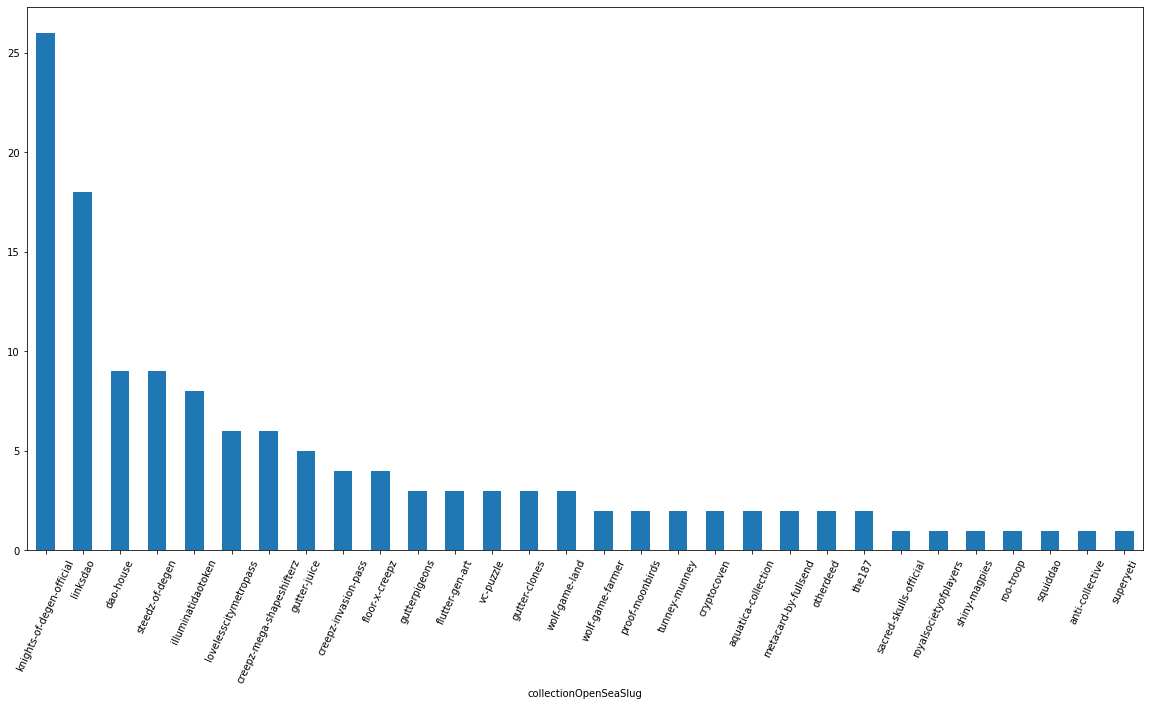

In [44]:
df_containsIllu.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"] \
    .count() \
    .sort_values(ascending=False) \
    .head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)